## Data analysis to identify the most and least profitable neighborhoods in New York City

Importing essential packages and data

In [142]:
import pandas as pd
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
sale=pd.read_csv('sale_2.csv', index_col=0)
rent=pd.read_csv('rent_2.csv',index_col=0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


After web scraping and data manipulation, we can finally begin to analyze our data!

My goal here is to **identify the most and least profitable neighborhoods in New York City to buy apartments as investment** (not considering how much money you have in your bank account!) <br/ > The ideal neighborhood for investing apartments would have 
1. high rental price
2. low sale price <br\ >
So the rent would be higher than the monthly mortgage payment to make a profit.

To achieve my goal, I need a way to compare the rental prices and sale prices. For each neighborhood, I calculated two things:
1. unit price per square foot for rental prices, and unit price per square foot for sale prices
2. averaged monthly mortgage under the assumption of 20% down payment, 3.5% annual interest rate, and 30 years mortgage period. 

In [193]:
#for sale 
    #mortgage
p=sale.price*0.8
i=0.035/12
n=30*12
m=p*(i*(1+i)**n)/((1+i)**n-1)
sale['monthly']=m

group=sale.groupby('where')
def unitprice(group):
    x1=group['price']
    x2=group['size']
    return x1.mean()/x2.mean()
unitPriceSale=pd.DataFrame(group.apply(unitprice))
unitPriceSale.columns=['unitPrice']
unitPriceSale['count']=group[['price','size']].agg('count').min(axis=1)
unitPriceSale['mortgage']=group[['monthly']].agg('mean')
unitPriceSale['neighborhood']=unitPriceSale.index


#for rent
group=rent.groupby('where')
def unitprice(group):
    x1=group['price']
    x2=group['size']
    return x1.mean()/x2.mean()
unitPriceRent=pd.DataFrame(group.apply(unitprice))
unitPriceRent.columns=['unitPrice']
unitPriceRent['count']=group[['price','size']].agg('count').min(axis=1)
unitPriceRent['rent']=group[['price']].agg('mean')
unitPriceRent['neighborhood']=unitPriceRent.index

#merge two data frames
dfMerge=pd.merge(unitPriceRent,unitPriceSale,on='neighborhood')
dfMerge['diff_mort']=dfMerge['rent']-dfMerge['mortgage']
dfMerge['count']=dfMerge[['count_x','count_y']].min(axis=1)
dfMerge.columns=['unitPrice_Rent','count_Rent','Rent','neighborhood',
                 'unitPrice_Sale','count_Sale','Mortgage','Rent-Mortgage','count']

Before we begin to compare rental price and sale price, it is important to have a first glance at the dataset.

I noticed that some neighborhoods have very few to none listing. The low number of listings could introduce instability and lead to false results. Therefore, I removed neighborhoods with equal or less than 5 listings to ensure the quality of the data.  


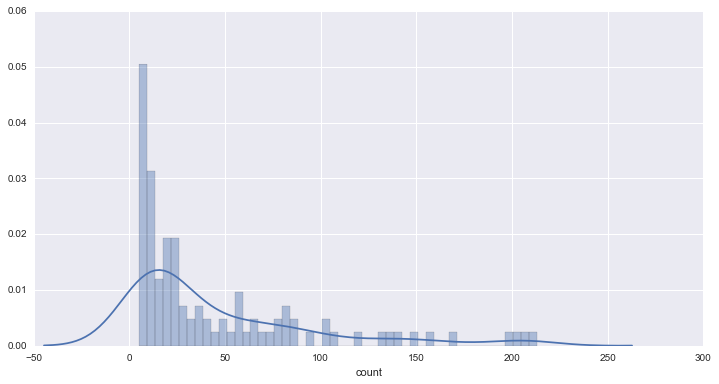

In [205]:
sns.set(rc={"figure.figsize": (12, 6)})
sns.distplot(dfMerge['count'], bins=50)
dfMerge=dfMerge.loc[dfMerge['count']>=5,]

Here are some examples of the neighborhoods with more than 5 listings. For instance, one square foot in Astoria costs \$2.95 to rent and \$792 to buy, and one square foot in Battery Park City costs \$6.15 to rent and \$2010.6 to buy. <br\ >
We can expect a linear relationship between the rent unit price and sale unit price; if it costs more to buy, it should cost more to rent. I am interested in the outliers of this linear regression. There are two types of outliers:
1. Outlier that are located above the regression line with abnormally high sale price 
2. Outliers that are located below the regression line with abnormally low sale price

Type 2 outliers are more likely to be profitable and type 1 outlier are less likely to be profitable.  

In [195]:
dfMerge[['neighborhood','unitPrice_Rent','unitPrice_Sale']][0:5]

,neighborhood,unitPrice_Rent,unitPrice_Sale
1,Astoria,2.950540,791.962523
4,Battery Park City,6.154510,2010.614176
5,Bay Ridge,2.146921,460.491860
9,Bedford-Stuyvesant,2.274522,628.070195
11,Beekman,5.503970,1230.677620


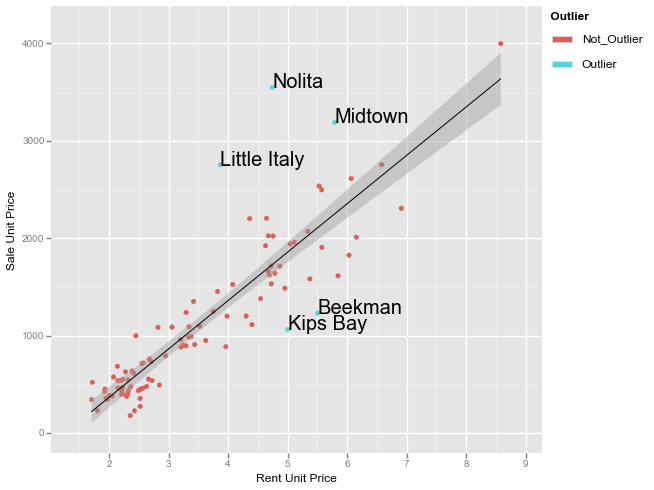

<ggplot: (290574785)>

In [204]:
from ggplot import *
import statsmodels.api as sm
from statsmodels.formula.api import ols
dfMerge.index=dfMerge['neighborhood']
model = ols("unitPrice_Sale ~ unitPrice_Rent", data=dfMerge).fit()

dfMerge['norm_resid']=abs(model.norm_resid())
dfMerge['outlier']=np.where(abs(model.norm_resid())>=2,'outlier','not_outlier')
dfMerge['name']=""
dfMerge.loc[dfMerge['norm_resid']>=2,'name']=dfMerge.loc[dfMerge['norm_resid']>=2,'neighborhood']
ggplot(dfMerge, aes(x='unitPrice_Rent',y='unitPrice_Sale',label='name'))+geom_text(hjust=0, vjust=0, size=20)+geom_point(dfMerge,aes(color='outlier'))+xlab("Rent Unit Price")+ylab("Sale Unit Price")+geom_smooth(method='lm')

Looking at the plot above, any points above the regression line have higher sale unit price than the fitted values, indicating they are less likely to be profitable. On the other hand, any points below the regression line have higher unit rental price than the fitted values, suggesting the higher likelihood of being profitable. Outliers are the extreme cases in these two circumstances. Outlier has the unusual, either very large or very small, y value given its x value. In other words, comparing to all the apartments with rental unit price of \$5, Kips Bay is has the lowest sale unit price, and therefore is the most profitable given rental price equals to \$5. However, it is not clear that it is the most profitable neighborhood comparing to the rest of neighborhoods located below the regression line.  For example, neighborhood X with \$500 sale unit price and \$2.9 rent unit price is more profitable than Kips Bay with \$1000 sale unit price and \$5 rent unit price, but neighborhood B is not an outlier.

To more accurately assess the profitabilities, I calculated the ratio of rent unit price over sale unit price and plotted the distribution of the ratios.

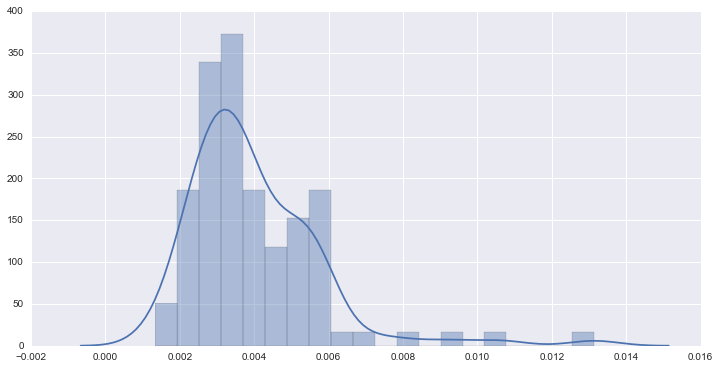

In [206]:
ratio=dfMerge['unitPrice_Rent']/dfMerge['unitPrice_Sale']
sns.set(rc={"figure.figsize": (12, 6)})
sns.distplot(ratio, bins=20)

From this analysis, the top 5 least profitable neighborhoods are listed below and showed in a map. This results matches the linear regression analysis. 

In [199]:
dfMerge['ratio']=ratio
dfMerge=dfMerge.sort_values(['ratio'], ascending=True)
dfMerge[['unitPrice_Rent','unitPrice_Sale','ratio','Rent','Mortgage','Rent-Mortgage']][0:5]

,unitPrice_Rent,unitPrice_Sale,ratio,Rent,Mortgage,Rent-Mortgage
neighborhood,,,,,,
Nolita,4.741653,3547.309390,0.001337,4700.333333,45771.766521,-41071.433187
Little Italy,3.867557,2754.327588,0.001404,4715.840909,29405.441912,-24689.601003
Midtown,5.790809,3189.108911,0.001816,8311.713873,22350.882449,-14039.168576
Carnegie Hill,4.362068,2201.382229,0.001982,4742.634615,25033.255051,-20290.620435
West Village,4.645301,2204.879907,0.002107,6439.949398,20077.223907,-13637.274509


<img "Least Profitable Neighborhoods" src="map/least_profitable.jpg" height="600px" width="600px"/>

Now, the top 5 most profitable neighborhoods are listed below and also showed in a map. 

In [200]:
dfMerge[['unitPrice_Rent','unitPrice_Sale','ratio','Rent','Mortgage','Rent-Mortgage']][::-1][0:5]

,unitPrice_Rent,unitPrice_Sale,ratio,Rent,Mortgage,Rent-Mortgage
neighborhood,,,,,,
Parkchester,2.352241,179.030318,0.013139,1696.750000,463.147206,1233.602794
Briarwood,2.425068,228.445413,0.010616,1809.761905,791.710761,1018.051144
Canarsie,2.521552,273.651582,0.009214,2925.000000,1723.157679,1201.842321
Northeast Flatbush,1.802829,229.117794,0.007869,1967.658537,1484.778014,482.880522
Spuyten Duyvil,2.519756,355.001923,0.007098,2405.204082,1629.745799,775.458283


<img "Most Profitable Neighborhoods" src="map/most_profitable.jpg" height="600px" width="600px"/>

This analysis is based solely on the active listings on StreetEasy.com on 2/18/2016. <br\ >
This analysis doesn't account for taxes, HOA fees, insurance payments, and other fess besides mortgage. 
